In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
import joblib
torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
validation_data=pd.read_csv('./assets/processed dataset/validation dataset.csv')
test_data=pd.read_csv('./assets/processed dataset/test dataset.csv')
train_data=pd.read_csv('./assets/processed dataset/train dataset.csv')
scaler =joblib.load('./assets/scaler.gz')

In [4]:
df1=test_data
input_test=scaler.transform(df1)
input_test[0]

array([0.        , 0.25459318, 0.43522505, 0.29502573])

In [5]:
seq_length=180
#Getting x and y for testing
X_test=[]
Y_test=[]

for i in range(seq_length,input_test.shape[0]):
    #Input features from 0 to 59
    X_test.append(input_test[i-seq_length:i])
    #T2M at 60
    Y_test.append(input_test[i])

# converting into numpy arrays
X_test,Y_test=np.array(X_test),np.array(Y_test)
Y_test=Y_test.reshape(-1,4)
print(X_test.shape,Y_test.shape)

X_test = Variable(torch.Tensor(X_test))
Y_test = Variable(torch.Tensor(Y_test))
print(X_test.shape,Y_test.shape)

(1957, 180, 4) (1957, 4)
torch.Size([1957, 180, 4]) torch.Size([1957, 4])


In [6]:
#BILSTM Network definition
class NETWORK_BILSTM(nn.Module):

    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(NETWORK_BILSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,bidirectional=True).to(device)
        self.fc=nn.Linear(hidden_size*2,num_classes)
    
    def forward(self,x):
        output_lstm, (h_n,c_n) = self.lstm(x)
        input_fc=output_lstm[:,-1,:]
        output_fc=self.fc(input_fc).to(device)
        return output_fc

In [7]:
input_size=4
hidden_size=8
num_layers=1
num_classes=4

model=NETWORK_BILSTM(num_classes,input_size, hidden_size,num_layers)
model.load_state_dict(torch.load('./assets/trained models state/bilstm_state.pt'))
model.eval()


NETWORK_BILSTM(
  (lstm): LSTM(4, 8, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [8]:
#Testing model
Y_pred=model(X_test.to(device))
Y_pred=Y_pred.detach().numpy()

In [9]:
#MSE
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(Y_test,Y_pred)
mse

0.009122621

In [14]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
mase=mean_absolute_scaled_error(Y_test,Y_pred,y_train=Y_test)
mase

2.1304768806530334

In [20]:
def MASE(Actual, Predicted):
    absolute_error = []
    naive_error = []
    for i in range(1, len(Actual)):
        absolute_error.append(abs(Actual[i] - Predicted[i]))       
        naive_error.append(abs(Actual[i] - Actual[i-1]))       
    mae= np.mean(absolute_error)
    mne=np.mean(naive_error)
    return mae/mne

In [21]:
MASE(Y_test,Y_pred)

2.1299999


(dot.exe:5680): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


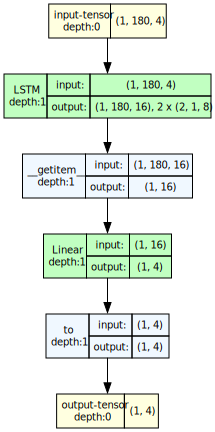

In [13]:
import torchvision
from torchview import draw_graph
with torch.no_grad():
    model_graph = draw_graph(model, input_size=(1,180,4), expand_nested=True)
model_graph.visual_graph